In [12]:
import tensorflow as tf

import keras_gradient_noise

from smot.jupyter import model_reports
from smot.problems.mnist import mnist_lib

In [13]:
# Load (and cache) standard MNIST dataset.
(x_train, y_train), (x_test, y_test) = mnist_lib.load_mnist_data_28x28x1()

In [14]:
model = mnist_lib.build_ijcal2011_mnist_model(
    optimizer=keras_gradient_noise.add_gradient_noise(tf.keras.optimizers.Adam)()
)

# Print the model summary.
model.summary()

batch_size = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    validation_split=0.2,
)
datagen.fit(x_train)

training_generator = datagen.flow(
    x_train,
    y_train,
    subset="training",
    batch_size=batch_size,
)
validation_generator = datagen.flow(
    x_train,
    y_train,
    subset="validation",
    batch_size=batch_size,
)

Model: "LeNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 40)        20040     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 40)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 60)          60060     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 60)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 80)          12008

Epoch 1/100
375/375 [==============================] - 4s 9ms/step - loss: 0.7522 - accuracy: 0.7518 - val_loss: 0.1298 - val_accuracy: 0.9610
Epoch 2/100
375/375 [==============================] - 4s 9ms/step - loss: 0.1082 - accuracy: 0.9659 - val_loss: 0.0907 - val_accuracy: 0.9713
Epoch 3/100
375/375 [==============================] - 4s 9ms/step - loss: 0.0868 - accuracy: 0.9731 - val_loss: 0.0799 - val_accuracy: 0.9766
Epoch 4/100
375/375 [==============================] - 4s 9ms/step - loss: 0.0759 - accuracy: 0.9755 - val_loss: 0.0739 - val_accuracy: 0.9783
Epoch 5/100
375/375 [==============================] - 4s 9ms/step - loss: 0.0591 - accuracy: 0.9801 - val_loss: 0.0631 - val_accuracy: 0.9812
Epoch 6/100
375/375 [==============================] - 4s 8ms/step - loss: 0.0536 - accuracy: 0.9835 - val_loss: 0.0499 - val_accuracy: 0.9843
Epoch 7/100
375/375 [==============================] - 4s 9ms/step - loss: 0.0539 - accuracy: 0.9833 - val_loss: 0.0538 - val_accuracy: 0.9833

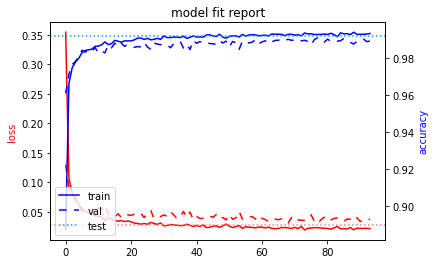

In [15]:
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1,
    use_multiprocessing=True,
    workers=12,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20),
    ],
)

# Evaluate the model with the test data.
test_loss, test_accuracy = model_reports.model_fit_report(
    model=model,
    history=history,
    test_data=(x_test, y_test),
)